# Синтез изображений. Часть 1. Вариационный Автоэнкодер (VAE)

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# %matplotlib inline  # Специальная команда для Jupyter Notebook, чтобы графики matplotlib отображались прямо в блокноте.

import matplotlib.pyplot as plt  # Импорт библиотеки matplotlib для построения графиков и визуализации данных.
import numpy as np               # Импорт библиотеки numpy для работы с массивами и математическими операциями.

import tensorflow as tf          # Импорт библиотеки TensorFlow — популярного фреймворка для машинного обучения и нейросетей.


## Загрузка и подготовка датасета MNIST

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
# Загружаем датасет MNIST — набор из 70 000 черно-белых изображений рукописных цифр (0-9).
# train_x и test_x — сами изображения (в виде массивов пикселей).
# train_y и test_y — метки классов (цифры от 0 до 9), соответствующие изображениям.
# Данные разбиты на тренировочную (train) и тестовую (test) части.

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
# Переформатируем тренировочные изображения:
# - reshape(-1, 28, 28, 1): меняем форму массива, чтобы добавить размерность канала цвета.
#   '-1' значит: автоматически определить число изображений.
#   28x28 — размер каждого изображения.
#   1 — количество каналов (т.к. изображение черно-белое, канал один).
# - astype(np.float32): преобразуем данные в тип float32, чтобы было удобнее работать с нейросетями.
# - делим на 255.: нормализуем пиксели из диапазона 0–255 в диапазон 0–1, что улучшает обучение модели.

test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
# Аналогично преобразуем тестовые изображения.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Визуализация датасета MNIST

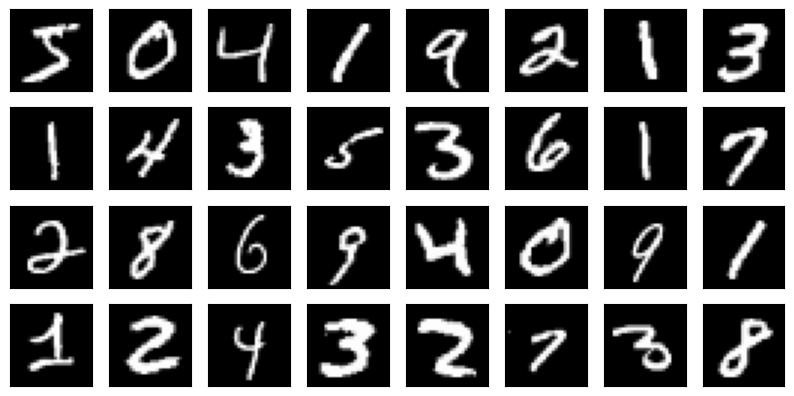

In [4]:
def plot_digits(samples):
    # Функция для отображения набора изображений цифр из массива samples

    fig = plt.figure(figsize=(10, 10))
    # Создаем новую фигуру (окно для графиков) размером 10 на 10 дюймов.

    for j in range(samples.shape[0]):
        # Проходим по всем изображениям в samples по индексу j.

        ax = fig.add_subplot(8, 8, j+1)
        # Добавляем подграфик в сетке 8x8 (максимум 64 изображения).
        # j+1 — номер подграфика (начинается с 1).

        ax.imshow(samples[j,:,:,0], cmap='gray')
        # Отображаем j-е изображение:
        # samples[j,:,:,0] — берем j-й элемент, все пиксели по высоте и ширине, 0-й канал (ч/б изображение).
        # cmap='gray' — задаем цветовую карту оттенков серого.

        plt.xticks([]), plt.yticks([])
        # Убираем подписи и деления по осям X и Y для каждого подграфика, чтобы не мешали просмотру.

    plt.show()
    # Показываем собранную фигуру с изображениями.

plot_digits(train_x[:32, ...])
# Вызов функции с первыми 32 изображениями из train_x.
# [:32, ...] — берем первые 32 картинки со всеми остальными измерениями.


## Создание Энкодера и Декодера

In [5]:
class Encoder(tf.keras.Model):
    # Создаем класс Encoder (кодировщик) для извлечения признаков из изображения и сжатия их в вектор.
    def __init__(self):
        super().__init__()
        # Вызываем конструктор базового класса tf.keras.Model.

        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')
        # Сверточный слой с 32 фильтрами размером 5x5.
        # padding='same' — выход того же размера, что и вход.
        # activation='relu' — нелинейность ReLU для активации.

        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu')
        # Второй сверточный слой с 64 фильтрами, те же параметры.

        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        # Полносвязный слой с 256 нейронами и ReLU.

        self.fc_mean = tf.keras.layers.Dense(2, activation=None)
        # Полносвязный слой для вычисления среднего (mean) латентного представления размерности 2.
        # activation=None — линейная активация, т.е. без изменений.

        self.fc_log_sigma = tf.keras.layers.Dense(2, activation=None)
        # Полносвязный слой для вычисления логарифма дисперсии (log_sigma) латентного пространства, размер 2.

        self.max_pool = tf.keras.layers.MaxPool2D((2, 2), (2, 2))
        # Слой подвыборки (max pooling) с размером окна 2x2 и шагом 2 — уменьшает размерность в 2 раза.

        self.flatten = tf.keras.layers.Flatten()
        # Преобразует многомерный тензор в одномерный для подачи на полносвязные слои.

    def call(self, inp):
        # Метод, который вызывается при передаче данных через модель.

        out = self.conv1(inp)
        # Пропускаем вход через первый сверточный слой.

        out = self.max_pool(out)
        # Применяем подвыборку, уменьшая размерность.

        out = self.conv2(out)
        # Второй сверточный слой.

        out = self.max_pool(out)
        # Еще одна подвыборка.

        out = self.flatten(out)
        # Разворачиваем тензор в вектор.

        out = self.fc1(out)
        # Полносвязный слой.

        z_mean = self.fc_mean(out)
        # Получаем среднее латентного кода.

        z_log_sigma = self.fc_log_sigma(out)
        # Получаем логарифм дисперсии (вариация для VAE).

        rnd = tf.random.normal(tf.shape(z_mean))
        # Генерируем случайный шум с тем же размером, что и z_mean (нормальное распределение).

        z = z_mean + tf.exp(z_log_sigma) * rnd
        # Формируем латентный вектор z с использованием "reparameterization trick":
        # берем среднее + экспоненту логарифма дисперсии * случайный шум.
        # Это нужно для обучения вариационного автокодировщика (VAE).

        return z_mean, z_log_sigma, z
        # Возвращаем среднее, логарифм дисперсии и сгенерированный латентный вектор.

class Decoder(tf.keras.Model):
    # Класс Decoder (декодировщик) восстанавливает изображение из латентного вектора.

    def __init__(self):
        super().__init__()
        # Конструктор базового класса.

        self.fc1 = tf.keras.layers.Dense(7*7*64, activation='relu')
        # Полносвязный слой, увеличивающий размерность до 7*7*64 — подготовка к обратному свертке.

        self.conv1 = tf.keras.layers.Conv2D(64, (5, 5), padding='valid', activation='relu')
        # Сверточный слой с 64 фильтрами и активацией ReLU.
        # padding='valid' — без заполнения, выход меньше входа.

        self.conv2 = tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu')
        # Второй сверточный слой с 32 фильтрами.

        self.conv3 = tf.keras.layers.Conv2D(1, (5, 5), padding='valid', activation='sigmoid')
        # Третий сверточный слой, который восстанавливает 1-канальное изображение.
        # Активация sigmoid для вывода значения пикселей в диапазоне [0,1].

        self.upsample = tf.keras.layers.UpSampling2D((2, 2))
        # Слой увеличения размерности изображения в 2 раза (обратная операция max pooling).

    def call(self, inp):
        batch_size = inp.shape[0]
        # Получаем размер батча (количество образцов одновременно).

        out = self.fc1(inp)
        # Пропускаем вход (латентный вектор) через полносвязный слой.

        out = tf.reshape(out, (batch_size, 7, 7, 64))
        # Переформатируем в тензор размером 7x7 с 64 каналами для сверточных операций.

        out = self.upsample(out)
        # Увеличиваем размерность в 2 раза (до 14x14).

        out = self.conv1(out)
        # Сверточный слой для обработки.

        out = self.upsample(out)
        # Снова увеличиваем размерность (до 28x28).

        out = self.conv2(out)
        # Второй сверточный слой.

        out = self.upsample(out)
        # Еще раз увеличиваем размерность (до 56x56).

        out = self.conv3(out)
        # Последний сверточный слой с активацией sigmoid, выводящий изображение.

        return out
        # Возвращаем восстановленное изображение.

encoder = Encoder()
# Создаем экземпляр кодировщика.

decoder = Decoder()
# Создаем экземпляр декодировщика.


## Инференс и функция потерь для VAE

In [6]:
def vae(inp):
    # Функция модели вариационного автокодировщика (VAE), принимает входное изображение inp.

    _, _, z = encoder(inp)
    # Пропускаем inp через энкодер.
    # Возвращаются z_mean и z_log_sigma, но здесь берём только сгенерированный латентный вектор z.

    out = decoder(z)
    # Пропускаем латентный вектор z через декодер, чтобы получить восстановленное изображение.

    return out
    # Возвращаем восстановленное изображение.

def vae_loss(inp, target):
    # Функция для вычисления потерь (loss) вариационного автокодировщика.
    # inp — входное изображение, target — ожидаемый результат (обычно равен inp для автокодировщика).

    z_mean, z_log_sigma, z = encoder(inp)
    # Пропускаем вход через энкодер, получаем параметры распределения и латентный вектор.

    pred = decoder(z)
    # Восстанавливаем изображение из латентного вектора.

    mse_loss = tf.reduce_sum(tf.square(pred - target), axis=[1, 2, 3])
    # Вычисляем MSE (mean squared error) — квадратичную ошибку между предсказанием и целью.
    # tf.square(pred - target) — поэлементная квадратичная разница.
    # tf.reduce_sum по осям 1,2,3 суммирует ошибку по высоте, ширине и каналам для каждого примера в батче.

    tmp = 1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma)
    # Вычисляем часть KL-дивергенции (регуляризация латентного пространства):
    # 1 + log(σ²) - μ² - σ², где μ = z_mean, σ² = exp(z_log_sigma).

    KL_loss = -0.5 * tf.reduce_sum(tmp, axis=-1)
    # Считаем KL-дивергенцию, уменьшающуюся при приближении распределения к нормальному.
    # reduce_sum по последней оси (по размерности латентного пространства).
    # Умножаем на -0.5 согласно формуле вариационного вывода.

    return tf.reduce_mean(mse_loss + KL_loss)
    # Возвращаем среднее по батчу сумму MSE и KL потерь — итоговый loss для обучения.


## Подготовка пайплайна данных и оптимизатора

In [7]:
NUM_EPOCHS = 25
# Количество эпох обучения — сколько раз весь тренировочный набор будет полностью пройден моделью.

BATCH_SIZE = 128
# Размер батча — сколько примеров обрабатывается за один шаг обучения.

LEARNING_RATE = 0.001
# Скорость обучения — параметр, регулирующий, насколько сильно обновляются веса модели на каждом шаге.

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
# Создаем объект Dataset из массива train_x.
# Dataset — удобный инструмент TensorFlow для управления данными (перебор, батчи, перемешивание).

train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
# Перемешиваем датасет случайным образом.
# buffer_size=train_x.shape[0] — размер буфера для перемешивания, здесь равен количеству всех примеров.

train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
# Разбиваем датасет на батчи по 128 изображений.
# drop_remainder=True — если в конце останется меньше 128, эти данные не будут использованы (важно для одинакового размера батчей).

optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)
# Создаем оптимизатор RMSprop с указанным learning rate.
# RMSprop — алгоритм градиентного спуска с адаптивным шагом, хорошо работает для нейросетей.


## Обучение VAE

[Epoch  0] Train Loss: 35.1845


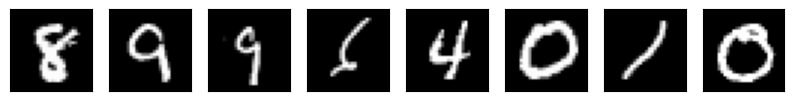

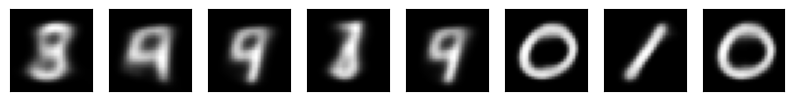

[Epoch  1] Train Loss: 35.8784


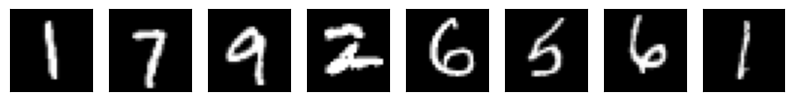

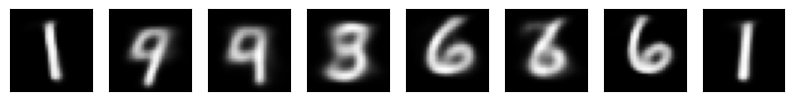

[Epoch  2] Train Loss: 34.3305


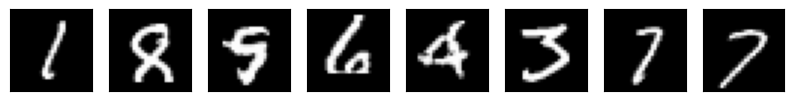

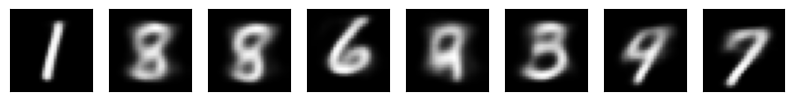

[Epoch  3] Train Loss: 33.6155


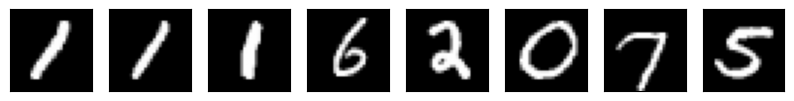

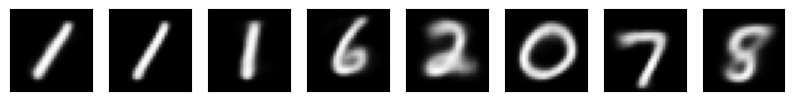

[Epoch  4] Train Loss: 35.2778


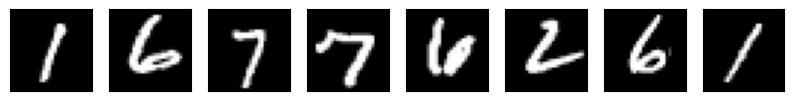

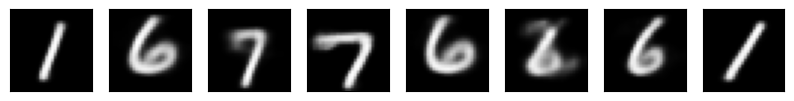

[Epoch  5] Train Loss: 33.0142


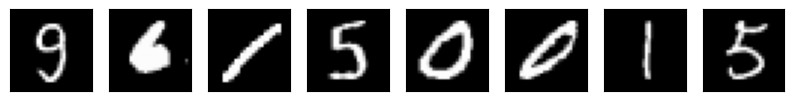

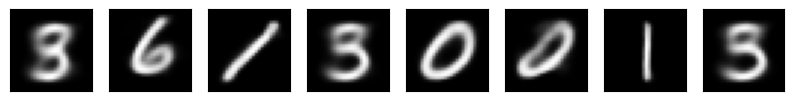

[Epoch  6] Train Loss: 33.1827


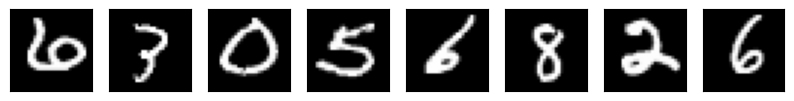

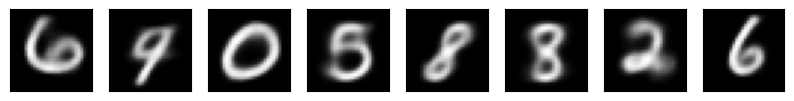

[Epoch  7] Train Loss: 31.7401


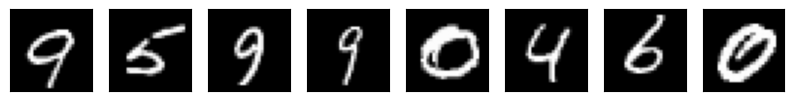

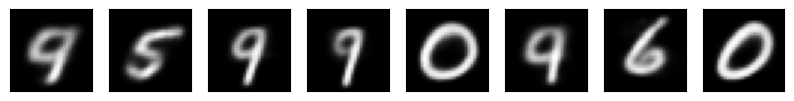

[Epoch  8] Train Loss: 33.2540


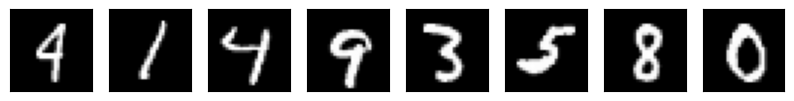

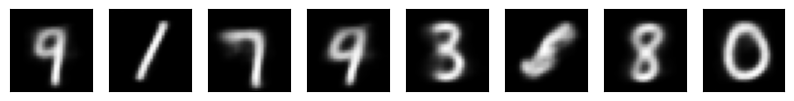

[Epoch  9] Train Loss: 29.1077


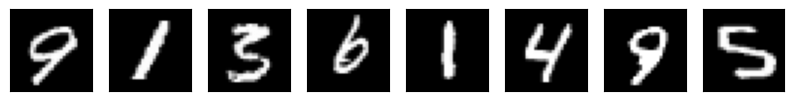

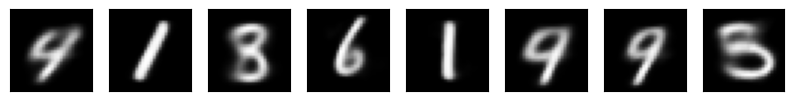

[Epoch 10] Train Loss: 33.2934


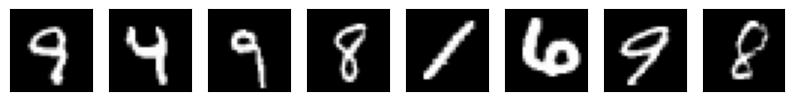

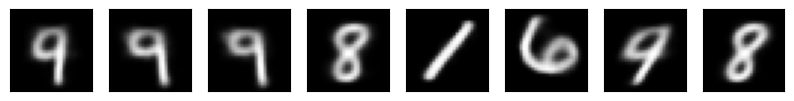

[Epoch 11] Train Loss: 33.3434


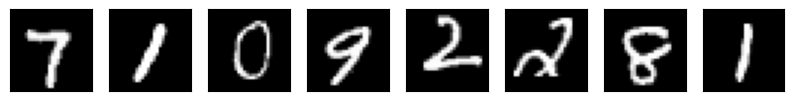

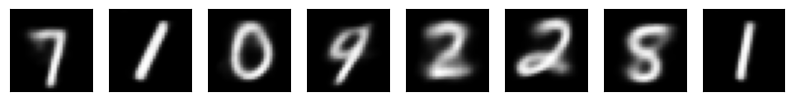

[Epoch 12] Train Loss: 30.3068


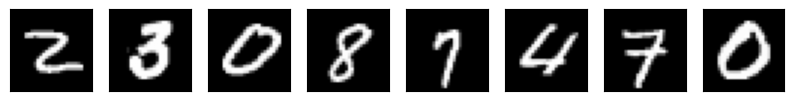

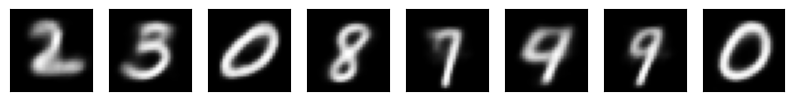

[Epoch 13] Train Loss: 32.9450


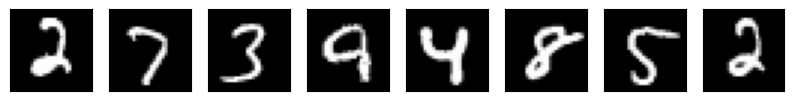

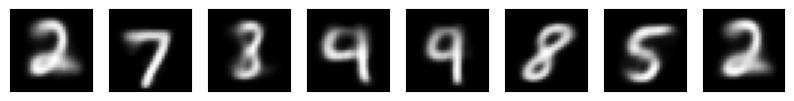

[Epoch 14] Train Loss: 31.9552


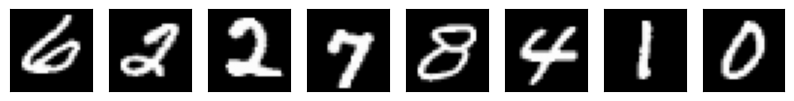

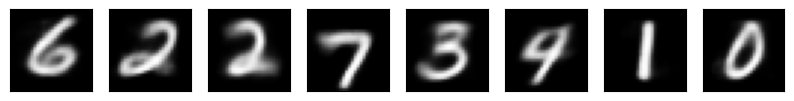

[Epoch 15] Train Loss: 30.8163


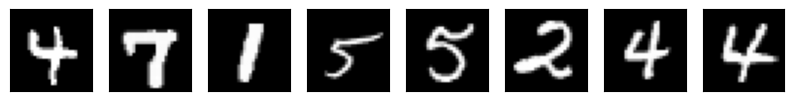

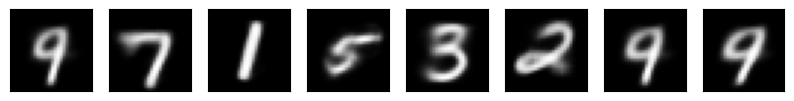

[Epoch 16] Train Loss: 34.2621


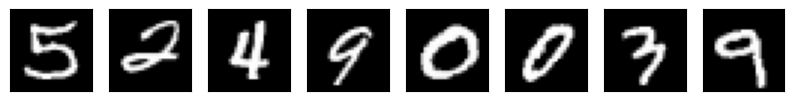

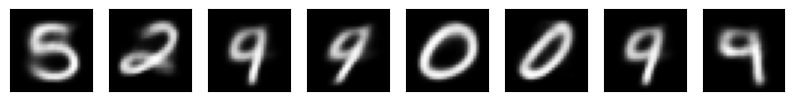

[Epoch 17] Train Loss: 30.7509


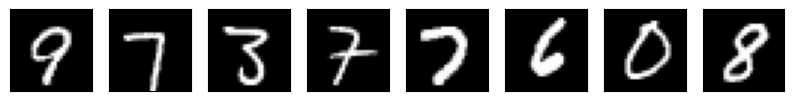

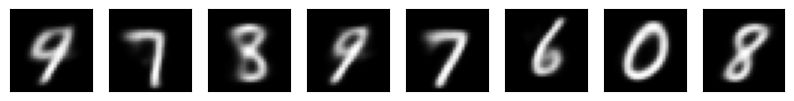

[Epoch 18] Train Loss: 30.7894


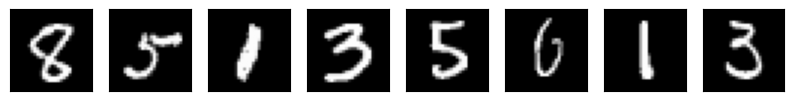

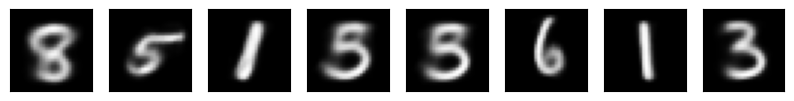

[Epoch 19] Train Loss: 31.4276


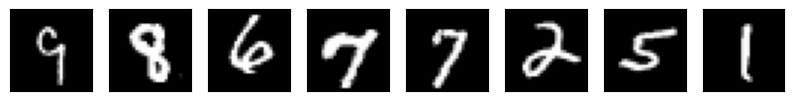

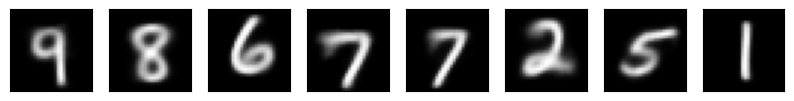

[Epoch 20] Train Loss: 30.7713


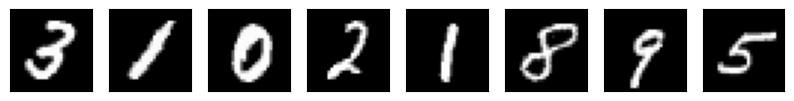

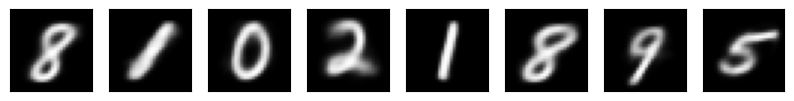

[Epoch 21] Train Loss: 33.2759


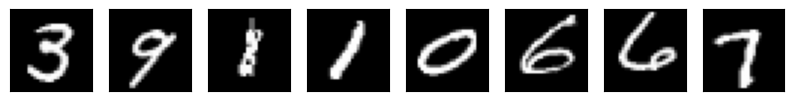

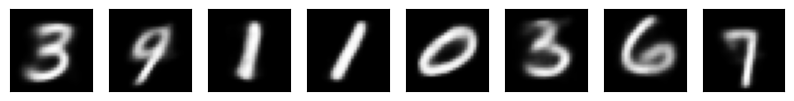

[Epoch 22] Train Loss: 29.9820


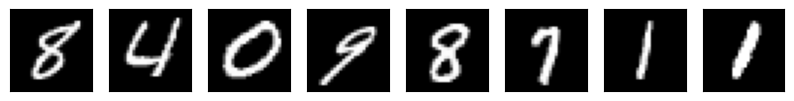

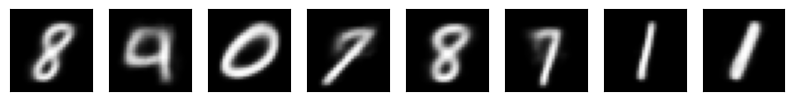

[Epoch 23] Train Loss: 27.7233


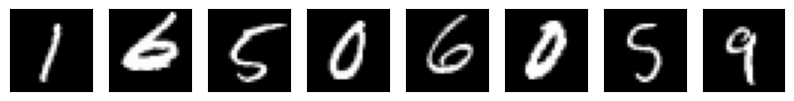

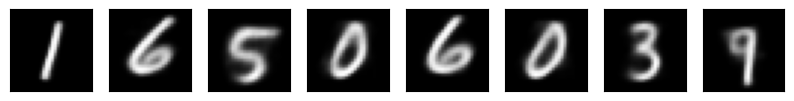

[Epoch 24] Train Loss: 31.8548


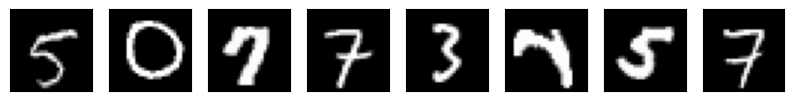

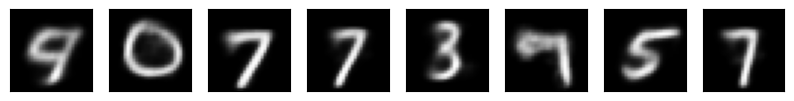

In [8]:
for e in range(NUM_EPOCHS):
    # Цикл по эпохам обучения (NUM_EPOCHS = 25).
    # Каждая эпоха — полный проход по всему тренировочному датасету.

    for batch in train_ds:
        # Итерация по батчам из датасета train_ds.
        # Каждый batch содержит BATCH_SIZE (128) изображений.

        with tf.GradientTape() as tape:
            # Создаем контекст GradientTape — TensorFlow автоматически отслеживает операции для вычисления градиентов.

            loss_value = vae_loss(batch, batch)
            # Вычисляем функцию потерь vae_loss для текущего батча.
            # Аргументы batch, batch — вход и цель одинаковы, так как автокодировщик восстанавливает вход.

        train_vars = encoder.variables + decoder.variables
        # Получаем список всех обучаемых переменных (весов) из энкодера и декодера.

        grads = tape.gradient(loss_value, train_vars)
        # Вычисляем градиенты функции потерь по всем обучаемым переменным.

        optimizer.apply_gradients(zip(grads, train_vars))
        # Обновляем веса модели с помощью оптимизатора (RMSprop),
        # применяя рассчитанные градиенты.

    print("[Epoch %2d] Train Loss: %.4f" % (e, loss_value.numpy()))
    # Выводим в консоль номер эпохи и значение последней функции потерь, преобразованное в число.

    batch_pred = vae(batch[0:8])
    # Пропускаем первые 8 изображений из последнего батча через модель VAE для предсказания.

    plot_digits(batch[0:8])
    # Визуализируем первые 8 исходных изображений из батча.

    plot_digits(batch_pred)
    # Визуализируем первые 8 изображений, сгенерированных моделью (восстановленных).


## Применение VAE на тестовых образцах

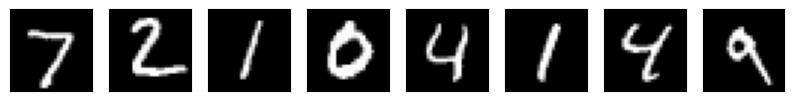

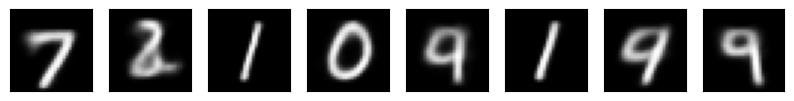

In [9]:
text_x_pred = vae(test_x[0:8])
# Пропускаем первые 8 изображений из тестового набора через модель VAE,
# чтобы получить восстановленные версии этих изображений.

plot_digits(test_x[0:8])
# Визуализируем первые 8 оригинальных изображений из тестового набора.

plot_digits(text_x_pred)
# Визуализируем первые 8 изображений, восстановленных моделью,
# чтобы визуально сравнить качество восстановления.


## VAE в режиме синтеза. Интерполяция в латентном пространстве

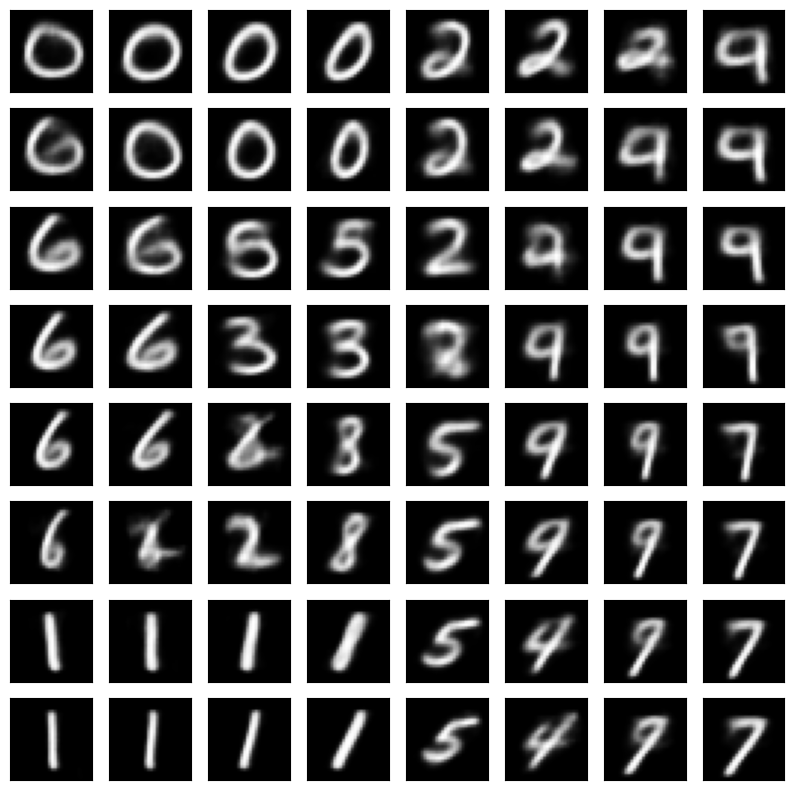

In [10]:
generated_list = []
# Создаем пустой список для хранения сгенерированных изображений.

for xi in np.linspace(-1, 1, 8):
    for xj in np.linspace(-1, 1, 8):
        # Перебираем значения xi и xj равномерно от -1 до 1, по 8 точек на каждой оси.
        # Это создает сетку координат в латентном пространстве размером 8x8.

        generated = decoder(np.array([[xi, xj]]).astype(np.float32))
        # Преобразуем координаты (xi, xj) в массив float32 и передаем в декодер,
        # чтобы сгенерировать изображение, соответствующее этим координатам в латентном пространстве.

        generated_list.append(generated)
        # Добавляем сгенерированное изображение в список.

plot_digits(np.concatenate(generated_list))
# Объединяем все изображения из списка по первой оси (батчу) в один массив
# и визуализируем их сеткой.
